## IMPORTING LIBRARIES AND DATASET DOWNLOAD AND PRETRAINED MODELS

In [1]:
# System Libraries
import os
import pickle
import random
import time

# Loop libraries
from tqdm import tqdm
from itertools import product

# Handling Data Libraries
import pandas as pd
import numpy as np

# display libraries
from IPython.display import Audio, clear_output
import warnings

# Plot Libraries
import matplotlib.pyplot as plt
from matplotlib import cm
import plotly.express as px
import seaborn as sns

# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files.
import librosa
import librosa.display

# text handling libraries
import re

# ML libraries
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from sklearn.metrics import confusion_matrix, classification_report, f1_score, accuracy_score
from sklearn.model_selection import train_test_split

# DL libraries
import tensorflow as tf
import keras as ks

EMO     = ['Anger', 'Happiness', 'Sadness', 'Neutral', 'Frustration', 'Excited', 'Fear', 'Surprise', 'Disgust', 'Other']
EMO_SIX = ['neu', 'fru', 'ang', 'sad', 'hap', 'exc']
VAD     = ['valence', 'activation', 'dominance']
TAG_ID  = ['session_id', 'conv_id', 'turn_id']

label2id = {'neu': 0, 'fru': 1, 'ang': 2, 'sad': 3, 'hap': 4, 'exc': 5, 'dis': 6, 'fea': 7, 'oth': 8, 'sur': 9, 'xxx': 10}

# setting a seed (will be later used as input to other funcs)
random_seed = 42

# printing numpy arrays on single lines
np.set_printoptions(linewidth=np.inf)

# Decide or not if you want to save the results on your drive by changing to True use_drive

use_drive = True
if use_drive:
    from google.colab import drive
    drive_folder = os.path.join(os.getcwd(), 'gdrive')
    drive.mount(drive_folder)
    new_drive_folder = 'NLP_Models'
    models_folder = os.path.join(drive_folder, 'MyDrive', new_drive_folder)
    if not os.path.exists(models_folder):
        os.makedirs(models_folder)
        print(f"{new_drive_folder} folder is created in your drive!")
    new_drive_folder_logs = 'NLP_models_ArchAndWeights'
    models_folder_logs = os.path.join(drive_folder, 'MyDrive', new_drive_folder_logs)
    if not os.path.exists(models_folder_logs):
        os.makedirs(models_folder_logs)
        print(f"{new_drive_folder_logs} folder is created in your drive!")
else:
    models_folder = os.path.join(os.getcwd(), 'NLP_Models')
    if not os.path.exists(models_folder):
        os.makedirs(models_folder)
        print(f"{models_folder} folder is created!")

Mounted at /content/gdrive


The dataset is distributed on this webpage https://sail.usc.edu/iemocap/ under request, after the request is accepted they provide you a download link that expire in 48 hours therefore we uploaded a lighter copy of it on kaggle as a private dataset (only the files we were interested in), therefore to run the following cell you just have to ask the access to Riccardo Paolini, we will provide you the access as soon as possible, then you have to download a ***kaggle.json*** file from kaggle to do that follow this steps:
- go to https://www.kaggle.com/
- sign up/in to your account on kaggle
- click on your propic in the top right corner
- click "Your Profile -> Account -> Create New API Token"

after this steps the download of your ***kaggle.json*** file should have started.
By running the following cell you are requested to upload the ***kaggle.json*** therefore the download of the private dataset should start.

In [2]:
if use_drive:
  from google.colab import files
  #files.upload()
  !echo '{"username":"ekinderpeskinder","key":"7bf2fa567986da7324e3a29c6519959a"}' | cat > kaggle.json
  !ls -lha kaggle.json
  !pip install -q kaggle # Install kaggle API
  !mkdir -p ~/.kaggle
  !cp kaggle.json ~/.kaggle/
  !chmod 600 /root/.kaggle/kaggle.json
  !kaggle datasets download -d riccardopaolini/nlp-project-work
  !unzip nlp-project-work.zip
  clear_output()

In [3]:
use_text_transformers = False

transformer_name = "albert-base-v2"

if use_text_transformers:
    ! pip install transformers
    from transformers import AutoTokenizer, TFAutoModel

    text_transformer_tokenizer = AutoTokenizer.from_pretrained(transformer_name)
    text_transformer = TFAutoModel.from_pretrained(transformer_name)

    max_len_text_transformer = text_transformer.config.max_position_embeddings # THIS IS THE TRUE MAX_LEN OF EMO_ROBERTA
    text_transformer_tokenizer_params = {
        'padding': 'max_length', # pads to the max_length if given otherwise pads to max_lenght of the model
        'truncation': True,
        'max_length': max_len_text_transformer,
        'return_tensors': 'np'
    }
    clear_output()

In [4]:
sample_rate = 16000
use_audio_transformers = False

if use_audio_transformers:
    ! pip install transformers

    from transformers import TFWav2Vec2Model, AutoFeatureExtractor

    audio_transformer_name = "facebook/wav2vec2-base"  # Name of pretrained model from Hugging Face Model Hub

    wav2vec2 = TFWav2Vec2Model.from_pretrained(audio_transformer_name, apply_spec_augment=False, from_pt=True)
    feature_extractor = AutoFeatureExtractor.from_pretrained(audio_transformer_name, return_attention_mask=True)

    clear_output()

## DATASET DESCRIPTION (Copy Paste of the README.txt file of the dataset)

Thank you for your interest in the USC_IEMOCAP database.  The USC_IEMOCAP database contains audio, transcriptions, video, and motion-capture(MoCap) recordings of dyadic mixed-gender pairs of actors.  There are five sessions in the database (ten actors total). For complete information about IEMOCAP please refer to:

Busso, Carlos et al.  "IEMOCAP: Interactive emotional dyadic motion capture database."  Journal of Language Resources and Evaluation.  Volume 42, Number 4.  pp. 335-359.  2008

as well as our website: http://sail.usc.edu/iemocap/

The recorded dialogs are either improvisations of affective scenarios, or performances of theatrical scripts. They have been manually segmented into utterances. Each utterance from either of the actors in the interaction has been evaluated categorically over the set of: {angry, happy, sad, neutral, frustrated, excited, fearful, surprised, disgusted, other} by at least three different annotators, and dimensionally over the axes of: valence (positive vs. negative); activation (calm vs. excited); and dominance (passive vs. aggressive) by at least two different annotators.

In each recording of a session only one actor wears MoCap markers while both are being recorded by microphones and cameras. Thus there are available MoCap data (facial expression, head and hand movement) for one actor per recording, while there are wavefile and videos for both actors. The naming convention regarding the data is e.g., Ses01F_impro01 while indicates Session1, where the Female actor is wearing the markers and actors are performing improvisation 1. The release contains two formats: dialog format which contains data from the entire dyadic interaction and the sentence format where the data per dialog (recording) have been further segmented into utterances (see folders SessionX/dialog and SessionX/sentences respectively). For the utterance format the naming is as follows: Ses01F_impro01_M000 indicates first session, Female actor is wearing markers, actors are performing improvisation 1 and this is the first utterance of the Male actor. The timing of the sentences in each dialog can be found in the lab files in SessionX/dialog/lab

The MoCap data can be found in either dialog format or sentece format in the corresposding folders. The MOCAP_rotated folder contains motion-capture data rotated and translated such that the central nose marker always represents the (0,0,0) xyz-tuple. The MoCap data are in .txt files where each line is a frame number and each column is a marker coordinate. Please consult the headers of the MoCap files and the diagram of the facial markers (Documentation/FIVE_face_markers2.png) to see the correspondence between marker positions and marker names. The hand mocap data is in MOCAP_hand folder, while the information of head translation (x,y,z) and head rotation (yaw, pitch, roll) is in MOCAP_head folder.

We are also distributing wavefiles (sentence and dialog format), the videos of the recordings (SessionX/dialog/avi/), and transcriptions of the dialogs (SessionX/dialog/transcriptions/). For the segmented utterances we are also providing the results of forced alignment which contain detail phoneme, syllable and word level timing information (SessionX/sentences/ForcedAlignment/).

The evaluations (emotional annotations) for each recording and each uterance are contained in folder SessionX/dialog/Evaluation/. Each file provides the detailed evaluation reports for the categorical evaluators (e.g., C-E1), the dimensional evaluators (e.g., A-E1), and the self-evaluatiors (e.g., C-F1 or C-M1, A-F1 or A-M1). The utterance-level information can be found in the first line of an utterance summary.  The first entry represents the start and end times for the utterance.  The second entry is the utterance name (e.g., Ses01_impro01_F003).  The third entry is the ground truth (if no majority ground truth could be assigned, the ground truth is labeled xxx).  The final engry is the average dimensional evaluation (over the evaluators, except the self-evaluators).

We are providing  a full release of this data in the hopes that it will provide a valuable resource to the emotion recognition community. We request that any published work using IEMOCAP should cite the paper entitled: "IEMOCAP: Interactive emotional dyadic motion capture database" (JLRE, 2008). If you do any further evaluation of the data, we request that you send us the detailed results so that we may provide a more detailed resource to the community. Also, please feel free to send us feedback regarding the database: how it is being used, if the information provided is sufficient, and how you have decided to utilize the evaluation information. Thanks again.


## BUILDING OF A DATAFRAME

In [5]:
folder = os.path.join(os.getcwd(), 'IEMOCAP')

conv_id = 0

df = []
for session in ['Session1','Session2','Session3','Session4','Session5']:
    session_path = os.path.join(folder, session)
    # 'dialogue' folder contains Emotions and Transcripts
    # 'sentences' folder contains Audios

    trans_folder = os.path.join(session_path, 'dialog', 'transcriptions')

    for trans_name in np.sort(os.listdir(trans_folder)):
        if trans_name[:2] != '._':
            emo_path = os.path.join(session_path, 'dialog', 'EmoEvaluation', trans_name)
            with open(os.path.join(trans_folder, trans_name), encoding='utf8') as trans_file, open(emo_path, encoding='utf8') as emo_file:
                conv_id += 1
                turn_id = 0
                for line in trans_file:
                    audio_name, text = line.split(':')
                    if trans_name.split('.')[0] in audio_name:
                        turn_id += 1

                        wav_path = os.path.join(session_path, 'sentences', 'wav', trans_name.split('.')[0], audio_name.split(' ')[0] + '.wav')

                        reached = False
                        count_em = {'Anger': 0, 'Happiness': 0, 'Sadness': 0, 'Neutral': 0, 'Frustration': 0, 'Excited': 0, 'Fear': 0, 'Surprise': 0, 'Disgust': 0, 'Other': 0}
                        for emo_line in emo_file:
                            if audio_name.split(' ')[0] in emo_line:
                                emotion, vad = emo_line.split('\t')[-2:]
                                vad = vad[1:-2].split(',')
                                reached = True
                            elif emo_line[0] == 'C' and reached:
                                evaluator = emo_line.split(':')[0]
                                emotions = emo_line.split(':')[1].split('(')[0].split(';')
                                emotions = [em.strip() for em in emotions]
                                for em in emotions:
                                    if em != '':
                                        count_em[em] += 1
                            elif reached:
                                emo_file.seek(0)
                                break


                        row = {'session_id': int(session[-1]),
                                'conv_id': conv_id,
                                'turn_id': turn_id,
                                'sentence': text.strip(),
                                'path': wav_path,
                                'emotion': emotion,
                                'valence': float(vad[0]),
                                'activation': float(vad[1]),
                                'dominance': float(vad[2])
                                }

                        df.append(dict(**row, **count_em))

df = pd.DataFrame(df)

idx = np.array([os.path.exists(path) for path in df.path])
print(f'Missing Audios: {np.sum(~idx)}')
print('Missing Sentences:')
print(df.iloc[~idx,3])
df = df.iloc[idx, :]

Missing Audios: 48
Missing Sentences:
3854    [LAUGHTER], That's what they say.
3866                            Mmm, Hmm.
3880                                Yeah.
3898                               Kelly.
3915                           Yeah, man.
3939                      Uh-huh, uh-huh.
3961                              Uh-huh.
3968                                Yeah.
3972                                Yeah.
4010                       Well, I don't-
4044                                Yeah.
4827                        But, Listen--
4847                                Yeah.
4873                                Yeah.
4975                          We- I mean-
4991                                Okay.
5005                                Yeah.
5051                              Thanks.
5124                        to start off.
5181                                okay.
5192                                Okay.
5208                                Okay.
7893                                  

## DATA INSPECTION

### DATAFRAME INSPECTION

In [6]:
print(df.shape)
df.head()

(10039, 19)


,session_id,conv_id,turn_id,sentence,path,emotion,valence,activation,dominance,Anger,Happiness,Sadness,Neutral,Frustration,Excited,Fear,Surprise,Disgust,Other
0,1,1,1,Excuse me.,/content/IEMOCAP/Session1/sentences/wav/Ses01F...,neu,2.5,2.5,2.5,0,0,0,4,0,0,0,0,0,0
1,1,1,2,Do you have your forms?,/content/IEMOCAP/Session1/sentences/wav/Ses01F...,fru,2.5,2.0,2.5,0,0,0,1,3,0,0,0,0,1
2,1,1,3,Yeah.,/content/IEMOCAP/Session1/sentences/wav/Ses01F...,neu,2.5,2.5,2.5,1,0,0,4,0,0,0,0,0,0
3,1,1,4,Let me see them.,/content/IEMOCAP/Session1/sentences/wav/Ses01F...,fru,2.5,2.0,2.5,0,0,0,0,3,0,0,0,0,1
4,1,1,5,Is there a problem?,/content/IEMOCAP/Session1/sentences/wav/Ses01F...,neu,2.5,2.5,2.5,1,0,0,3,0,0,0,1,0,0


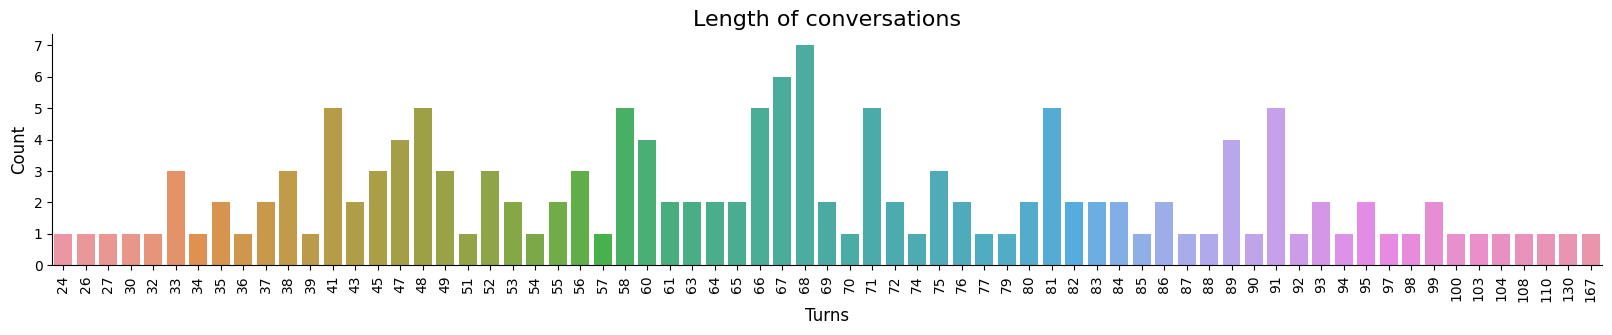

In [7]:
df_turn_count = df.groupby(['session_id','conv_id'])['conv_id'].count().rename('turns').reset_index()
max_conv_length = df_turn_count['turns'].max()

plt.figure(figsize=(20, 3))
plt.title('Length of conversations', size=16)
sns.countplot(x=df_turn_count['turns'])

plt.ylabel('Count', size=12)
plt.xlabel('Turns', size=12)
plt.xticks(rotation = 90)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

In [8]:
df_conv_count = df_turn_count.groupby(['session_id'])['session_id'].count().rename('convs').reset_index()
df_conv_count

,session_id,convs
0,1,28
1,2,30
2,3,32
3,4,30
4,5,31


### AUDIO INSPECTION

In [9]:
if use_audio_transformers:
    quantile=0.1 # WE HANDLE ONLY 0.5% OF THE LENGTH OF THE AUDIOS RIGHT NOW
    unpack_librosa_load = lambda *kwargs: kwargs[0]
    max_seq_length = int(np.quantile([len(unpack_librosa_load(*librosa.load(p, sr=sample_rate))) for p in df.path], quantile))
    max_seq_length = ((1 if (max_seq_length % sample_rate) != 0 else 0) + (max_seq_length//sample_rate)) * sample_rate
    max_duration = max_seq_length//sample_rate
    audio_transformer_params = {'sampling_rate':feature_extractor.sampling_rate, 'max_length':max_seq_length, 'truncation':True, 'padding':True}
    print(f'Raw Audios truncated and padded to {max_duration} seconds') # quantile 1 -> 35 seconds

In [10]:
show_sample = 191
Audio(df.iloc[show_sample, 4], autoplay=True) # ispection of the first audio (to change audio just change the first index)

### TEXT INSPECTION

In [11]:
# LITE PROCESSING (THINK IF WE HAVE TO KEEP IT)
def text_lite_preprocessing(data, column):
  df = data.copy()
  df[column] = df[column].apply(lambda x: str(x).lower())
  df[column] = df[column].apply(lambda x: re.sub(r'\d', "number", x))
  df[column] = df[column].apply(lambda x: re.sub("_", "number", x))
  return (df)

new_df = text_lite_preprocessing(df, 'sentence')

show_sample = 1
if use_text_transformers: # TRANSFORMER TOKENIZER
    unpack_tokens = lambda **kwargs: (kwargs['input_ids'], kwargs['attention_mask'])
    input_ids, attention_mask = unpack_tokens(**text_transformer_tokenizer(new_df.sentence.tolist(), **text_transformer_tokenizer_params))

    # printing tokenization example
    print("## Before tokenization: ")
    print(new_df.loc[show_sample, 'sentence'])
    print("\n## After tokenization: ")
    print(input_ids[show_sample, attention_mask[show_sample,:] == 1])
    print("\n## Token Meanings: ")
    print(text_transformer_tokenizer.convert_ids_to_tokens(input_ids[show_sample,attention_mask[show_sample,:] == 1]))

else: # OLD TOKENIZER
    # creating tokenizer and fitting it on the training set
    tokenizer = ks.preprocessing.text.Tokenizer(num_words = None, oov_token='<UNK>', split=' ', lower=False)
    tokenizer.fit_on_texts(new_df.loc[new_df.session_id <= 3, 'sentence'])

    # printing a tokenization example
    print("## Before tokenization: ")
    print(new_df.loc[show_sample,'sentence'])
    print("\n## After tokenization: ")
    print(tokenizer.texts_to_sequences(new_df.sentence)[show_sample])
    print('\n## Token Meanings: ')
    tokenizer_reverse_word_map = dict(map(reversed, tokenizer.word_index.items()))
    print([tokenizer_reverse_word_map[s] for s in tokenizer.texts_to_sequences(new_df.sentence)[show_sample]])

## Before tokenization: 
do you have your forms?

## After tokenization: 
[18, 3, 26, 49, 535]

## Token Meanings: 
['do', 'you', 'have', 'your', 'forms']


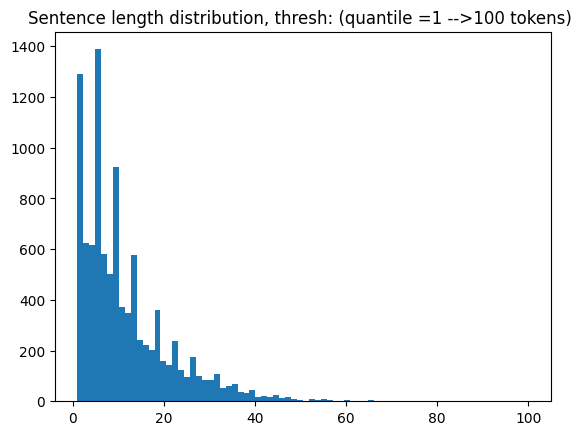

In [12]:
# drawing plot of the sentences length distribution
if use_text_transformers:
    lengths = np.sum(attention_mask, axis=1)
else:
    lengths = [len(sequence) for sequence in tokenizer.texts_to_sequences(new_df['sentence'])]

quantile = 1 # was 0.99
max_sentence_len = int(np.quantile(lengths, quantile))

plt.hist(lengths, bins = len(set(lengths)))
plt.title(f"Sentence length distribution, thresh: (quantile ={quantile} -->{max_sentence_len} tokens) ")
if quantile != 1:
    plt.axvline(x = max_sentence_len, color = 'r', label = 'axvline - full height')
plt.show()
if use_text_transformers:
    max_sentence_len = max_len_text_transformer
    # emo_roberta_tokenizer_params['max_length'] = max_sentence_len

### GOLDEN LABELS INSPECTION

Let's do some consideration of the following plotted distribution of the golden labels:

- We can see how the emotion "xxx" is very common emotion (almost 2500 occurrences) but not very meaningful, our explanation behind the behavior of this golden label is that there isn't a predominant emotion in the classifications of the evaluators (excluding the self-evaluator) therefore an "xxx" gold label shows up.

- We can see that a lot of our labels are undersampled in comparison to the other labels, data augmentation could help in this cases

The strategies that we thinked of for handling the "xxx" labels are by considering them as missing values and trying to fill them by reconstruct a predominant emotion also considering the self-evaluators with more weights with respect to the other evaluators, but that would by definition modify the golden label we are provided with.

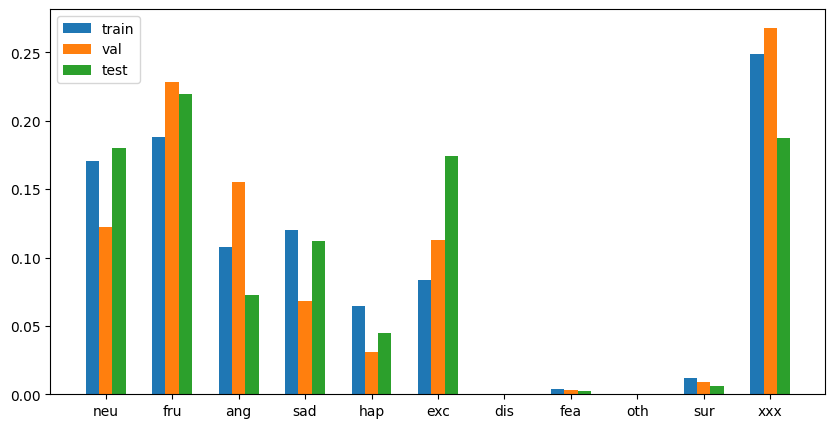

In [13]:
train_em  = df[df['session_id'] <= 3]['emotion']
val_em    = df[df['session_id'] == 4]['emotion']
test_em   = df[df['session_id'] == 5]['emotion']

train_em_freq = {em: np.sum(train_em == em) / len(train_em) for em in label2id}
val_em_freq   = {em: np.sum(val_em == em) / len(val_em)     for em in label2id}
test_em_freq  = {em: np.sum(test_em == em) / len(test_em)   for em in label2id}

n = len(label2id.keys())
r = np.arange(n)
width = 0.2

plt.figure(figsize=(10, 5))
plt.bar(r, train_em_freq.values(), width = width, label='train')
plt.bar(r + width, val_em_freq.values(), width = width, label='val')
plt.bar(r + 2* width, test_em_freq.values(), width = width, label='test')
plt.legend()
plt.xticks(r + width, [em for em in label2id])
plt.show()

### VAD Inspection (Valence, Activation, Dominance)

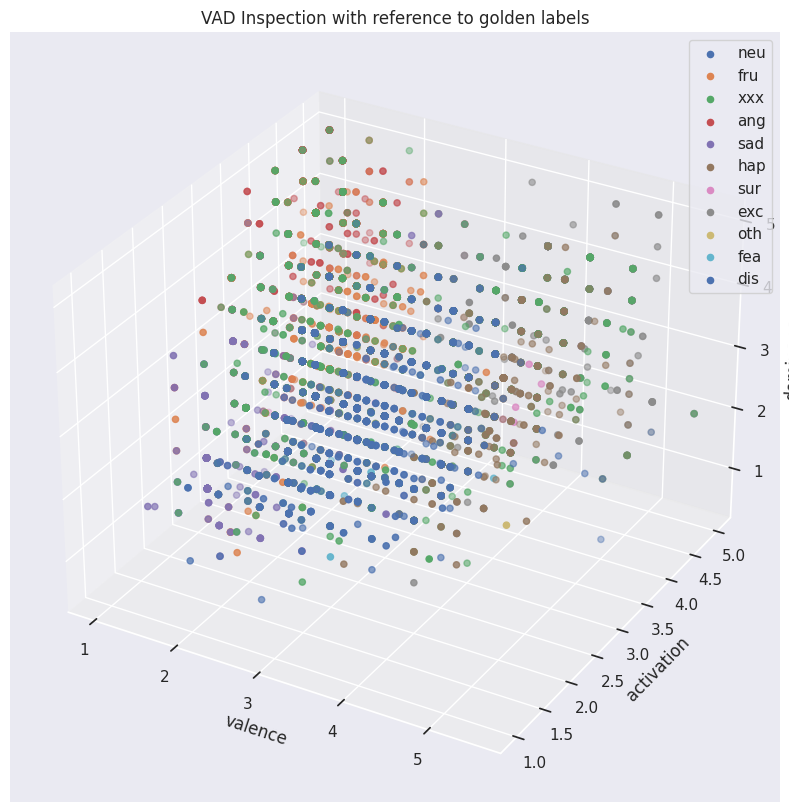

In [14]:
interactive = False # CHANGE THIS TO False IN ORDER TO SEE AN INTERACTIVE PLOT
title = "VAD Inspection with reference to golden labels"

if interactive:
    fig = px.scatter_3d(df, x='valence', y='activation', z='dominance',
                        color='emotion',
                        title=title)
    fig.show()
else:
    sns.set(style = "darkgrid")

    fig = plt.figure(figsize=(15,10), dpi= 100, facecolor='w', edgecolor='k')
    ax = fig.add_subplot(111, projection = '3d')

    for e in df.emotion.unique():
        ax.scatter(df.valence[df.emotion == e], df.activation[df.emotion == e], df.dominance[df.emotion == e], label = e)

    ax.set_xlabel("valence")
    ax.set_ylabel("activation")
    ax.set_zlabel("dominance")

    ax.legend()

    plt.title(title)
    plt.show()

The only inspection for the VAD values that came in our mind is a visual inspection with reference to the golden labels and it seems that the golden labels are reflected in the VAD space with some clusters, that doesn't seem to be the case for the 'xxx' label that seems to be distributed quite randomly in this space.

## Audio Features Extraction and Data Augmentation

In [15]:
def extract_features(df, feats, sr=sample_rate, save=False, feats_folder=None):
    # calculate features and save them eventually
    feats_dict = {feat: [] for feat in feats}

    for path in df['path']:
        audio, _ = librosa.load(path, sr=sr)

        if 'mfcc' in feats:
            # Mel-Frequency Cepstral Coefficients
            feats_dict['mfcc'].append(librosa.feature.mfcc(y=audio, sr=sr).T)

        if 'mel' in feats:
            # Melspectrogram
            feats_dict['mel'].append(librosa.feature.melspectrogram(y=audio, sr=sr).T)

        if 'chroma' in feats:
            # Chromagram
            feats_dict['chroma'].append(librosa.feature.chroma_stft(y=audio, sr=sr).T)

        if 'rms' in feats:
            # Root-Mean-Square value
            feats_dict['rms'].append(librosa.feature.rms(y=audio).T)

        if 'zcr' in feats:
            # Zero-Crossing Rate
            feats_dict['zcr'].append(librosa.feature.zero_crossing_rate(y=audio).T)

    if save:
        for feat in feats:
            with open(os.path.join(os.getcwd() if feats_folder is None else feats_folder, f'{feat}.pkl'), 'wb') as f:
                pickle.dump(feats_dict[feat], f)

    return feats_dict

def load_features(df, feats, feats_folder=None):
    feats_dict = {}
    for feat in feats:
        with open(os.path.join(os.getcwd() if feats_folder is None else feats_folder, f'{feat}.pkl'), "rb") as f:
            feats_dict[feat] = pickle.load(f)
    return feats_dict


if not use_audio_transformers:
    if use_drive:
        new_drive_folder = 'NLP_Features'
        features_folder = os.path.join(drive_folder, 'MyDrive', new_drive_folder)
        if not os.path.exists(features_folder):
            os.makedirs(features_folder)
            print(f"{new_drive_folder} folder is created in your drive!\n")
    else:
        features_folder = os.getcwd()

    # feats_to_use = ['mfcc', 'mel', 'chroma', 'rms', 'zcr'] # shapes = [(t,20),(t,128),(t,12),(t,1),(t,1)]
    feats_to_use = ['mfcc']
    override_features = False
    if override_features:
        audio_feats = extract_features(new_df, feats_to_use, save=True, feats_folder=features_folder)
    else:
        try:
            audio_feats = load_features(new_df, feats_to_use, feats_folder=features_folder)
        except:
            audio_feats = extract_features(new_df, feats_to_use, save=True, feats_folder=features_folder)

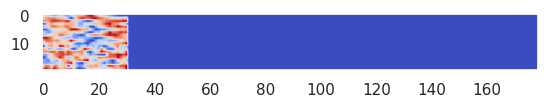

In [16]:
standardize = lambda x: (x - x.mean(axis=0)) / x.std(axis=0) # over the time
normalize = lambda x: (x - x.min(axis=0)) / (x.max(axis=0) - x.min(axis=0)) # over the time

def normalize_and_reshape(array, perc):
    #array = standardize(array)
    array = normalize(array) # What about the minimum value that is mapped to 0, is then ignored??
    if perc <= array.shape[0]:
        return array[:perc]
    else:
        return np.concatenate([array, np.zeros((perc - array.shape[0], array.shape[1]))], axis=0)

def process_features(feat_dict, perc=0.95):
    feats = feat_dict.copy()
    feat_list = feats.keys()
    for feat in feat_list:
        perc_val = int(np.quantile([x.shape[0] for x in feats[feat]], perc))
        feats[feat] = [normalize_and_reshape(x, perc_val) for x in feats[feat]]
    return feats

if not use_audio_transformers:
    audio_proc = process_features(audio_feats, perc=0.75)
    show_sample = 191
    plt.imshow(audio_proc[feats_to_use[0]][show_sample].T, cmap=cm.coolwarm)
    plt.grid(False)
    plt.show()

In [17]:
if use_audio_transformers:
    columns = TAG_ID + ['sentence', 'path', 'emotion']
    df_full = new_df.loc[:,columns]
else:
    columns = TAG_ID + ['sentence', 'emotion']
    df_full = new_df.loc[:,columns]
    for feat in feats_to_use:
        df_full.loc[new_df.index.to_list(),feat] = pd.Series(audio_proc[feat], index=new_df.index)

print(df_full.shape)
df_full.head()

(10039, 6)


,session_id,conv_id,turn_id,sentence,emotion,mfcc
0,1,1,1,excuse me.,neu,"[[0.219910129904747, 0.695990264415741, 0.4123..."
1,1,1,2,do you have your forms?,fru,"[[0.10549400746822357, 0.31732502579689026, 0...."
2,1,1,3,yeah.,neu,"[[0.09616019576787949, 0.0, 0.9581318497657776..."
3,1,1,4,let me see them.,fru,"[[0.02177649550139904, 0.5747396349906921, 0.3..."
4,1,1,5,is there a problem?,neu,"[[0.0, 0.4752722382545471, 0.7680443525314331,..."


## Build data for our model

In [18]:
def read_wav_file(file_path, sr=sample_rate):
    if file_path == '':
        audio = np.array([])
    else:
        audio, sample_rate = librosa.load(file_path, sr=sr)
        if sample_rate != sr:
            raise ValueError(f"sample rate (={sample_rate}) of your files must be {sr}")
    return audio

def get_text_data(df, tokenizer, text_tokenizer_params, conv_length, use_text_transformers):
    conv_ids = []
    for conv_id in df.conv_id.unique():
        padded_texts = ['']*(conv_length-1) + df[df.conv_id == conv_id].sentence.to_list()
        convs = [padded_texts[i:i+conv_length] for i in range(len(padded_texts)-conv_length+1)]
        if use_text_transformers:
            conv_ids += [unpack_tokens(**tokenizer(conv, **text_tokenizer_params)) for conv in convs]
        else:
            conv_ids += [np.array(ks.utils.pad_sequences(tokenizer.texts_to_sequences(conv), **text_tokenizer_params)) for conv in convs]
    if use_text_transformers:
        return np.array([conv[0] for conv in conv_ids]) , np.array([conv[1] for conv in conv_ids])
    return np.array(conv_ids)

def get_audio_data(df, feats_to_use, conv_length, use_audio_transformers, audio_params=None):
    if use_audio_transformers:
        unpack_audios = lambda **kwargs: (np.vstack(kwargs['input_values']), np.vstack(kwargs['attention_mask']))
    convs = []
    for conv_id in df.conv_id.unique():
        if use_audio_transformers:
            if audio_params is None:
                raise Exception("You need to set audio_params")
            padded_conv = [''] * (conv_length -1) + df[df.conv_id == conv_id][feats_to_use].to_list()
            for i in range(len(padded_conv) - conv_length + 1):
                convs += padded_conv[i:i+conv_length]
        else:
            audios = [np.concatenate([row[feat] for feat in feats_to_use], axis=1) for _, row in df[df.conv_id == conv_id].iterrows()]
            padded_audios = [np.zeros(audios[0].shape)] * (conv_length - 1) + audios
            convs += [padded_audios[i:i+conv_length] for i in range(len(padded_audios)-conv_length+1)]
    if use_audio_transformers:
        warnings.filterwarnings("ignore", category=RuntimeWarning)
        convs, convs_id = unpack_audios(**feature_extractor(pd.Series(convs).map(read_wav_file).to_list(), **audio_transformer_params))
        warnings.filterwarnings("default", category=RuntimeWarning)
        return convs.reshape((df.shape[0], conv_length, -1)) , convs_id.reshape((df.shape[0], conv_length, -1))
    return np.array(convs)
conv_length = 1
use_audio = True
use_text = True


# DATA SPLITTING
df_train  = df_full[df_full['session_id'] <= 3]
df_val    = df_full[df_full['session_id'] == 4]
df_test   = df_full[df_full['session_id'] == 5]


# PREPARE AUDIOS
if use_audio:
    if use_audio_transformers:
        audio_train, audio_train_mask = get_audio_data(df_train, 'path', conv_length, use_audio_transformers, audio_params=audio_transformer_params)
        audio_val, audio_val_mask = get_audio_data(df_val, 'path', conv_length, use_audio_transformers, audio_params=audio_transformer_params)
        audio_test, audio_test_mask = get_audio_data(df_test, 'path', conv_length, use_audio_transformers, audio_params=audio_transformer_params)
    else:
        audio_train = get_audio_data(df_train, feats_to_use, conv_length, use_audio_transformers)
        audio_val = get_audio_data(df_val, feats_to_use, conv_length, use_audio_transformers)
        audio_test = get_audio_data(df_test, feats_to_use, conv_length, use_audio_transformers)

# PREPARE TEXTS
if use_text:
    if use_text_transformers:
        text_data_params = (text_transformer_tokenizer, text_transformer_tokenizer_params, conv_length, use_text_transformers)
        text_train_ids, text_train_mask = get_text_data(df_train, *text_data_params)
        text_val_ids, text_val_mask = get_text_data(df_val, *text_data_params)
        text_test_ids, text_test_mask = get_text_data(df_test, *text_data_params)
    else:
        text_data_params = (tokenizer, {'truncating': 'post', 'padding': 'post', 'maxlen': max_sentence_len}, conv_length, use_text_transformers)
        text_train_ids = get_text_data(df_train, *text_data_params)
        text_val_ids = get_text_data(df_val, *text_data_params)
        text_test_ids = get_text_data(df_test, *text_data_params)

# PREPARE LABELS
em_train = tf.convert_to_tensor(ks.utils.to_categorical(df_train['emotion'].map(label2id),  num_classes=11))
em_val = tf.convert_to_tensor(ks.utils.to_categorical(df_val['emotion'].map(label2id),  num_classes=11))
em_test = tf.convert_to_tensor(ks.utils.to_categorical(df_test['emotion'].map(label2id),  num_classes=11))

# FULL DATA
train_data = []
val_data = []
test_data = []

if use_audio:
    train_data.append(audio_train)
    val_data.append(audio_val)
    test_data.append(audio_test)

if use_text:
    train_data.append(text_train_ids)
    val_data.append(text_val_ids)
    test_data.append(text_test_ids)

if use_audio_transformers and use_audio:
    train_data.append(audio_train_mask)
    val_data.append(audio_val_mask)
    test_data.append(audio_test_mask)

if use_text_transformers and use_text:
    train_data.append(text_train_mask)
    val_data.append(text_val_mask)
    test_data.append(text_test_mask)

# CHECK SHAPES

if use_audio:
    audio_feats_shape = audio_train.shape[2:]

print('Shapes:')
if use_text and use_audio:
    print(f'  -audio_train : {audio_train.shape}\t-text_train : {text_train_ids.shape}\t-em_train : {em_train.shape}')
    print(f'  -audio_val   : {audio_val.shape}\t-text_val   : {text_val_ids.shape}\t-em_val   : {em_val.shape}')
    print(f'  -audio_test  : {audio_test.shape}\t-text_test  : {text_test_ids.shape}\t-em_test  : {em_test.shape}')
else:
    if use_audio:
        print(f'  -audio_train : {audio_train.shape}\t-em_train : {em_train.shape}')
        print(f'  -audio_val   : {audio_val.shape}\t-em_val   : {em_val.shape}')
        print(f'  -audio_test  : {audio_test.shape}\t-em_test  : {em_test.shape}')
    if use_text:
        print(f'  -text_train : {text_train_ids.shape}\t-em_train : {em_train.shape}')
        print(f'  -text_val   : {text_val_ids.shape}\t-em_val   : {em_val.shape}')
        print(f'  -text_test  : {text_test_ids.shape}\t-em_test  : {em_test.shape}')

Shapes:
  -audio_train : (5766, 1, 179, 20)	-text_train : (5766, 1, 100)	-em_train : (5766, 11)
  -audio_val   : (2103, 1, 179, 20)	-text_val   : (2103, 1, 100)	-em_val   : (2103, 11)
  -audio_test  : (2170, 1, 179, 20)	-text_test  : (2170, 1, 100)	-em_test  : (2170, 11)


## Model Definition

In [19]:
def set_seeds(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(random_seed)
    np.random.seed(random_seed)
    tf.random.set_seed(random_seed)

def set_global_determinism(seed):
    set_seeds(seed=seed)

    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

    try:
        tf.config.threading.set_inter_op_parallelism_threads(1)
        tf.config.threading.set_intra_op_parallelism_threads(1)
    except Exception as e:
        print("An error occurred:", str(e))

# Call the above function with seed value
set_global_determinism(seed=random_seed)
classic_behavior = False
if classic_behavior:
    glorot_initializer = "glorot_uniform"
    uniform_initializer = "uniform"
    orthogonal_initializer = "orthogonal"
else:
    glorot_initializer = ks.initializers.glorot_uniform(seed=random_seed)
    uniform_initializer = ks.initializers.RandomUniform(seed=random_seed)
    orthogonal_initializer = ks.initializers.Orthogonal(seed=random_seed)

An error occurred: Inter op parallelism cannot be modified after initialization.


In [20]:
latent_embedding_dim = 256

def create_audio_transformer_model(audio_transformer, max_seq_len, latent_embedding_dim, trainable=False):
    audio_transformer.layers[0].trainable = trainable

    input_values = ks.Input(shape=(max_seq_len,))
    attention_mask = ks.Input(shape=(max_seq_len,))

    output = audio_transformer(input_values=input_values, attention_mask=attention_mask)

    output = ks.layers.GlobalAveragePooling1D()(output.last_hidden_state)

    output = ks.layers.Dense(units=latent_embedding_dim, activation='relu', kernel_initializer=glorot_initializer)(output)

    model = ks.models.Model(inputs = [input_values,attention_mask] ,outputs = output)
    return model

if use_audio:
    if use_audio_transformers:
        audio_embedder = create_audio_transformer_model(wav2vec2, max_seq_length, latent_embedding_dim)
    else:
        audio_embedder = ks.models.Sequential([
                ks.Input(audio_feats_shape),

                ks.layers.Conv1D(2*audio_feats_shape[-1], 3, strides=1, padding='same', activation='relu', kernel_initializer=glorot_initializer),
                ks.layers.Conv1D(2*audio_feats_shape[-1], 3, strides=2, padding='same', activation='relu', kernel_initializer=glorot_initializer),

                ks.layers.Conv1D(4*audio_feats_shape[-1], 3, strides=1, padding='same', activation='relu', kernel_initializer=glorot_initializer),
                ks.layers.Conv1D(4*audio_feats_shape[-1], 3, strides=2, padding='same', activation='relu', kernel_initializer=glorot_initializer),

                ks.layers.Conv1D(8*audio_feats_shape[-1], 3, strides=1, padding='same', activation='relu', kernel_initializer=glorot_initializer),
                ks.layers.Conv1D(8*audio_feats_shape[-1], 3, strides=2, padding='same', activation='relu', kernel_initializer=glorot_initializer),

                ks.layers.Bidirectional(ks.layers.LSTM(8*audio_feats_shape[-1], return_sequences=True, kernel_initializer=glorot_initializer, recurrent_initializer=orthogonal_initializer)),
                ks.layers.Bidirectional(ks.layers.LSTM(8*audio_feats_shape[-1], kernel_initializer=glorot_initializer, recurrent_initializer=orthogonal_initializer)),

                ks.layers.Dense(latent_embedding_dim, kernel_initializer=glorot_initializer)
    ])
    audio_embedder.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 179, 40)           2440      
                                                                 
 conv1d_1 (Conv1D)           (None, 90, 40)            4840      
                                                                 
 conv1d_2 (Conv1D)           (None, 90, 80)            9680      
                                                                 
 conv1d_3 (Conv1D)           (None, 45, 80)            19280     
                                                                 
 conv1d_4 (Conv1D)           (None, 45, 160)           38560     
                                                                 
 conv1d_5 (Conv1D)           (None, 23, 160)           76960     
                                                                 
 bidirectional (Bidirectiona  (None, 23, 320)          4

In [21]:
def create_text_transformer_model(text_transformer, max_len, latent_embedding_dim, trainable=False):
    text_transformer.layers[0].trainable = trainable

    input_ids = ks.Input(shape=(max_len,),dtype='int32')
    attention_mask = ks.Input(shape=(max_len,),dtype='int32')

    output = text_transformer(input_ids=input_ids, attention_mask=attention_mask)

    output = ks.layers.GlobalAveragePooling1D()(output.last_hidden_state)

    output = ks.layers.Dense(units=latent_embedding_dim, activation='relu', kernel_initializer=glorot_initializer)(output)

    model = ks.models.Model(inputs = [input_ids,attention_mask] ,outputs = output)

    return model

if use_text:
    if use_text_transformers:
        text_embedder = create_text_transformer_model(text_transformer, max_len_text_transformer, latent_embedding_dim)
    else:
        text_embedder = ks.models.Sequential([
                ks.layers.Embedding(tokenizer.document_count, 256, input_length=max_sentence_len, mask_zero=True, embeddings_initializer=uniform_initializer),
                ks.layers.Bidirectional(ks.layers.LSTM(256, return_sequences=True, kernel_initializer=glorot_initializer, recurrent_initializer=orthogonal_initializer)),
                ks.layers.Bidirectional(ks.layers.LSTM(256, kernel_initializer=glorot_initializer, recurrent_initializer=orthogonal_initializer)),
                ks.layers.Dense(units=latent_embedding_dim, activation='relu', kernel_initializer=glorot_initializer)
        ])

    text_embedder.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 256)          1476096   
                                                                 
 bidirectional_2 (Bidirectio  (None, 100, 512)         1050624   
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 512)              1574912   
 nal)                                                            
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
Total params: 4,232,960
Trainable params: 4,232,960
Non-trainable params: 0
_________________________________________________________________


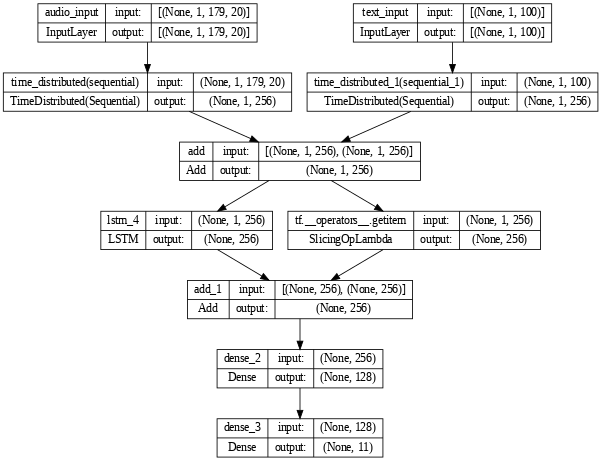

In [22]:
def make_multimodal_model(audio_embedder, audio_feats_shape, text_embedder, max_sentence_len,
                          deep_embedding_dim, conversation_dim, num_classes,
                          use_audio_attention, use_text_attention,
                          fusion_mode='concatenate', mask_conv = False,
                          use_audio=True, use_text=True):
    if not (use_audio or use_text):
        raise Exception("You need to set at True at least one of use_audio or use_text")

    if fusion_mode=='concatenate' and (use_audio and use_text):
        deep_embedding_dim = 2 * deep_embedding_dim

    if use_audio:
        audio_input_shape = (conversation_dim, *audio_feats_shape)
    if use_text:
        text_input_shape = (conversation_dim, max_sentence_len)

    # INPUTS
    inputs = []
    if use_audio:
        audio_input = ks.Input(audio_input_shape, name='audio_input')
        inputs.append(audio_input)
    if use_text:
        text_input = ks.Input(text_input_shape, name='text_input')
        inputs.append(text_input)
    if use_audio_attention and use_audio:
        audio_attention_input = ks.Input(audio_input_shape, name='audio_attention_mask')
        inputs.append(audio_attention_input)
    if use_text_attention and use_text:
        text_attention_input = ks.Input(text_input_shape, name='text_attention_mask')
        inputs.append(text_attention_input)

    # AUDIO EMBEDDER
    if use_audio:
        if use_audio_attention:
            if mask_conv:
                x_audio = ks.layers.TimeDistributed(audio_embedder)([audio_input, audio_attention_input], mask=ks.backend.all(audio_attention_input[...,2:]==0, axis=-1))
            else:
                x_audio = ks.layers.TimeDistributed(audio_embedder)([audio_input, audio_attention_input])
        else:
            if mask_conv:
                x_audio = ks.layers.TimeDistributed(audio_embedder)(audio_input, mask=ks.backend.all(audio_input==0, axis=-1))
            else:
                x_audio = ks.layers.TimeDistributed(audio_embedder)(audio_input)

    # TEXT EMBEDDER
    if use_text:
        if use_text_attention:
            if mask_conv:
                x_text = ks.layers.TimeDistributed(text_embedder)([text_input, text_attention_input], mask=ks.backend.all(text_attention_input[...,2:]==0, axis=-1))
            else:
                x_text = ks.layers.TimeDistributed(text_embedder)([text_input, text_attention_input])
        else:
            if mask_conv:
                x_text = ks.layers.TimeDistributed(text_embedder)(text_input, mask=ks.backend.all(text_input==0, axis=-1))
            else:
                x_text = ks.layers.TimeDistributed(text_embedder)(text_input)

    # AUDIO AND TEXT FUSION
    if use_audio and use_text:
        if fusion_mode == 'concatenate':
            skip_x = ks.layers.concatenate([x_audio, x_text], axis=-1)
        if fusion_mode == 'add':
            skip_x = ks.layers.Add()([x_audio, x_text])
        if fusion_mode == 'attention':
            skip_x = ks.layers.MultiHeadAttention(2, deep_embedding_dim)(x_audio, x_text)
    else:
        if use_audio:
            skip_x = x_audio
        if use_text:
            skip_x = x_text

    x = ks.layers.LSTM(deep_embedding_dim, kernel_initializer=glorot_initializer, recurrent_initializer=orthogonal_initializer)(skip_x)

    x = ks.layers.Add()([x, skip_x[:,-1,:]])

    x = ks.layers.Dense(units=deep_embedding_dim/2, activation='relu', kernel_initializer=glorot_initializer)(x)

    output = ks.layers.Dense(units=num_classes, activation='softmax', kernel_initializer=glorot_initializer)(x)

    model = ks.models.Model(inputs, output)

    return model

fusion_mode = 'add' # concatenate, add, attention
make_multimodal_params = {
    'audio_embedder': audio_embedder if use_audio else None,
    'audio_feats_shape': audio_feats_shape if use_audio else None,
    'text_embedder': text_embedder if use_text else None,
    'max_sentence_len': max_sentence_len if use_text else None,
    'deep_embedding_dim': latent_embedding_dim,
    'conversation_dim': conv_length,
    'num_classes': len(label2id),
    'use_audio_attention': use_audio_transformers,
    'use_text_attention': use_text_transformers,
    'fusion_mode': fusion_mode,
    'use_audio': use_audio,
    'use_text': use_text
}
model = make_multimodal_model(**make_multimodal_params)
ks.utils.plot_model(model, show_shapes=True, dpi=60)

In [23]:
class Masked_Categorical_Accuracy(ks.metrics.Metric):
    def __init__(self, ignore_indexes = [], name='categorical_accuracy', **kwargs):
        super(Masked_Categorical_Accuracy, self).__init__(name=name, **kwargs)
        self.ignore_indexes = ignore_indexes
        self.matches = self.add_weight(name='matches', initializer='zeros')
        self.total = self.add_weight(name='total', initializer='zeros')

    def update_state(self, label, pred, sample_weight=None):
        pred = tf.argmax(pred, axis=-1)
        label = tf.cast(tf.argmax(label, axis=-1), pred.dtype)
        matches = label == pred

        mask = tf.cast(tf.ones_like(matches), dtype='bool')
        for idx in self.ignore_indexes:
            mask = mask & (label != idx)

        matches = matches & mask
        matches = tf.cast(matches, dtype=tf.float32)
        mask = tf.cast(mask, dtype=tf.float32)
        self.matches.assign_add(tf.reduce_sum(matches))
        self.total.assign_add(tf.reduce_sum(mask))

    def result(self):
        return self.matches.value()/self.total.value()

    def reset_state(self):
        self.matches.assign(0.0)
        self.total.assign(0.0)


class Masked_F1(ks.metrics.Metric):
    def __init__(self, num_labels, mode='macro', name=None, ignore_indexes = [], dataset_distribution=None, **kwargs):
        # mode='weighted' and dataset_distribution=None is equivalent to mode='macro'
        super(Masked_F1, self).__init__(name=name, **kwargs)

        self.num_labels = num_labels
        self.mode = mode
        self.ignore_indexes = ignore_indexes
        self.dataset_distribution = dataset_distribution

        self.tp = tf.Variable(np.zeros((num_labels,)), shape=(num_labels,))
        self.fp = tf.Variable(np.zeros((num_labels,)), shape=(num_labels,))
        self.fn = tf.Variable(np.zeros((num_labels,)), shape=(num_labels,))

    def set_split_params(self, dataset_distribution):
        # the distribution changes continuously when fit is called (is setted to train and val thanks to ChangeTrainValBehaviour custom Callback)
        self.dataset_distribution = dataset_distribution

    def update_state(self, label, pred, sample_weight=None):
        batch_size = tf.size(label) / np.prod(label.shape[1:])
        shape = (batch_size, *label.shape[1:])

        if len(label.shape) >= 3:
            label = ks.backend.reshape(label, (batch_size * np.prod(label.shape[1:-1]),label.shape[-1]))
            pred = ks.backend.reshape(pred, (batch_size * np.prod(pred.shape[1:-1]),pred.shape[-1]))

        label = ks.backend.cast(ks.backend.equal(label, ks.backend.max(label, axis=1, keepdims=True)), tf.float32)
        pred = ks.backend.cast(ks.backend.equal(pred, ks.backend.max(pred, axis=1, keepdims=True)), tf.float32)

        tp = ks.backend.sum(ks.backend.cast(label*pred, 'float'), axis=0)
        fp = ks.backend.sum(ks.backend.cast((1-label)*pred, 'float'), axis=0)
        fn = ks.backend.sum(ks.backend.cast(label*(1-pred), 'float'), axis=0)

        self.tp.assign_add(tf.cast(tp, self.tp.value().dtype))
        self.fp.assign_add(tf.cast(fp, self.fp.value().dtype))
        self.fn.assign_add(tf.cast(fn, self.fn.value().dtype))

    def result(self):
        tp = self.tp.value()
        fn = self.fn.value()
        fp = self.fp.value()

        f1 = 2*tp / (2*tp+fn+fp+ks.backend.epsilon())

        mask = tf.cast(tf.ones_like(f1), dtype='bool')
        for idx in self.ignore_indexes:
            mask = mask & (tf.convert_to_tensor(np.arange(self.num_labels)) != idx)
        mask = tf.cast(mask, dtype=f1.dtype)

        f1 *= mask

        if self.mode == 'none':
            return f1
        if self.mode == 'macro':
            return ks.backend.sum(f1)/ks.backend.sum(mask)
        if self.mode == 'weighted':
            if self.dataset_distribution is None:
                dataset_distribution = tf.ones_like(f1) / ks.backend.sum(mask)
            else:
                dataset_distribution = tf.convert_to_tensor(self.dataset_distribution, dtype=f1.dtype) * mask
                dataset_distribution /= ks.backend.sum(dataset_distribution)
            return ks.backend.sum(f1 * dataset_distribution)

    def reset_state(self):
        self.tp.assign(tf.zeros_like(self.tp.value()))
        self.fp.assign(tf.zeros_like(self.fp.value()))
        self.fn.assign(tf.zeros_like(self.fn.value()))


class ChangeTrainValBehaviour(ks.callbacks.Callback):
    def __init__(self, monitor_metrics=[], train_params=[], val_params=[]):
        self.monitor_metrics = monitor_metrics
        self.train_params = train_params
        self.val_params = val_params

    def on_train_begin(self, logs):
        for i in range(len(self.monitor_metrics)):
            self.monitor_metrics[i].set_split_params(**self.train_params[i])

    def on_test_begin(self, logs):
        for i in range(len(self.monitor_metrics)):
            self.monitor_metrics[i].set_split_params(**self.val_params[i])

    def on_test_end(self,  logs):
        for i in range(len(self.monitor_metrics)):
            self.monitor_metrics[i].set_split_params(**self.train_params[i])


# PREPARE SAMPLE WEIGHTS
ignore_emotions = [em for em in label2id.keys() if em not in EMO_SIX]
bin_counts = np.bincount(df_train['emotion'].map(label2id))
class_weights = np.sum(bin_counts[[label2id[c] for c in EMO_SIX]])/(len(EMO_SIX)*bin_counts)
class_weights[[label2id[c] for c in ignore_emotions]] = 0
class_weights = {i:class_weights[i] for i in range(class_weights.size)}

# calculating the counting for each emotion using one of the sets (or combination of them) and ordering them in the same order of the network labels
train_freq  = df_train['emotion'].value_counts()
train_distr = {em: train_freq[em] / np.sum(train_freq[EMO_SIX]) if em in EMO_SIX else 0.0 for em in label2id.keys()}

val_freq    = df_val['emotion'].value_counts()
val_distr   = {em: val_freq[em] / np.sum(val_freq[EMO_SIX]) if em in EMO_SIX else 0.0 for em in label2id.keys()}

test_freq   = df_test['emotion'].value_counts()
test_distr  = {em: test_freq[em] / np.sum(test_freq[EMO_SIX]) if em in EMO_SIX else 0.0 for em in label2id.keys()}

f1_weighted_train_params = {'dataset_distribution': list(train_distr.values())}
f1_weighted_val_params = {'dataset_distribution': list(val_distr.values())}

print(train_distr)
print(class_weights)

{'neu': 0.23176776020769413, 'fru': 0.2556053811659193, 'ang': 0.1470379985839037, 'sad': 0.16332310597120603, 'hap': 0.08827000236016048, 'exc': 0.11399575171111635, 'dis': 0.0, 'fea': 0.0, 'oth': 0.0, 'sur': 0.0, 'xxx': 0.0}
{0: 0.7191106585200272, 1: 0.652046783625731, 2: 1.133493846976993, 3: 1.0204720616570329, 4: 1.8881461675579323, 5: 1.4620427881297446, 6: 0.0, 7: 0.0, 8: 0.0, 9: 0.0, 10: 0.0}


In [24]:
use_class_weights = True

model_name = f'conv{conv_length}_'
model_name += f'{fusion_mode}_' if use_audio and use_text else ""
if use_audio:
    model_name += "AudioTransformer" if use_audio_transformers else f'SimpleAudioModel_{"_".join([f for f in feats_to_use])}'
if use_audio and use_text:
    model_name += "&"
if use_text:
    model_name += "TextTransformer" if use_text_transformers else "SimpleTextModel"
model_name += f'_{"cw_" if use_class_weights else ""}'
model_name += f's{random_seed}'
model_path = os.path.join(models_folder, f'{model_name}.h5')
print(model_name)

conv1_add_SimpleAudioModel_mfcc&SimpleTextModel_cw_s42


## Model Training

In [25]:
if not use_class_weights:
    for emo in EMO_SIX:
        class_weights[emo] = 1.0

train_sample_weights = np.array(df_train['emotion'].map(label2id).map(class_weights).to_list())
val_sample_weights = np.array(df_val['emotion'].map(label2id).map(class_weights).to_list())
test_sample_weights = np.array(df_test['emotion'].map(label2id).map(class_weights).to_list())

override_model = False
batch_size = 16
if override_model:
    # COMPILE
    optimizer = ks.optimizers.Adam(1e-3)

    loss = ks.losses.CategoricalCrossentropy(name='loss')
    categorical_accuracy = Masked_Categorical_Accuracy(ignore_indexes = [label2id[emo] for emo in ignore_emotions], name='categorical_accuracy')
    f1_weighted = Masked_F1(len(label2id), mode='weighted', name='f1_weighted', ignore_indexes=[label2id[emo] for emo in ignore_emotions], dataset_distribution=list(train_distr.values()))

    model.compile(optimizer=optimizer, loss=loss, metrics=[categorical_accuracy, f1_weighted], weighted_metrics=[])

    # TRAIN
    callbacks = [
            ks.callbacks.ModelCheckpoint(model_path, save_weights_only=True, save_best_only = True, monitor="val_f1_weighted", mode='max', verbose=1),
            ks.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=1e-6),
            ks.callbacks.EarlyStopping(monitor='val_f1_weighted', patience=6, verbose=1, mode='min'),
            ChangeTrainValBehaviour(monitor_metrics=[f1_weighted], train_params=[f1_weighted_train_params], val_params=[f1_weighted_val_params])
        ]

    start = time.perf_counter()

    history=model.fit(train_data, em_train, batch_size=batch_size, epochs=100, validation_data=(val_data, em_val, val_sample_weights), callbacks=callbacks, sample_weight=train_sample_weights)

    elapsed = time.perf_counter() - start

    # save log with learning rate, optimizer, batch size, conv_length, f1, acc
    log_txt = 'optimizer: ' + str(optimizer.get_config()) + '\n' + 'batch_size: ' +'\n' + str(batch_size) + '\n' + 'conv_length: ' + '\n' + str(conv_length) + '\n' + 'BEST train categorical_accuracy: '+'\n' + str(np.max(history.history['categorical_accuracy']))+ '\n' + 'BEST train f1_weighted: ' +'\n' + str(np.max(history.history['f1_weighted'])) +'\n'  + 'BEST val categorical_accuracy: '+'\n' + str(np.max(history.history['val_categorical_accuracy']))+ '\n' + 'BEST val f1_weighted: ' +'\n' + str(np.max(history.history['val_f1_weighted'])) +'\n'+ 'elapsed_time: '+'\n' + str(elapsed)
    log_txt += '\n'+'additional info: ' + ''
    log_file = open(f"/content/gdrive/MyDrive/NLP_models_ArchAndWeights/log_{model_name}.txt", "w")
    log_file.write(log_txt)
    log_file.close()

model.load_weights(model_path)

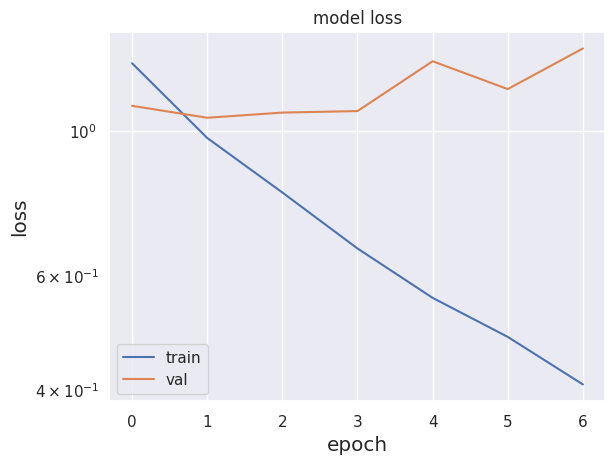

In [26]:
metric = "loss"
if override_model:
    plt.figure()
    plt.plot(history.history[metric])
    plt.plot(history.history["val_" + metric])
    plt.title("model " + metric)
    plt.ylabel(metric, fontsize="large")
    plt.xlabel("epoch", fontsize="large")
    plt.legend(["train", "val"], loc="best")
    plt.yscale('log')
    with open(os.path.join(models_folder, f'{model_name}_{metric}.pickle'), 'wb') as f:
        fig = plt.gcf()
        pickle.dump(fig, f)
else:
    with open(os.path.join(models_folder, f'{model_name}_{metric}.pickle'), 'rb') as f:
        fig = pickle.load(f)
fig.show()


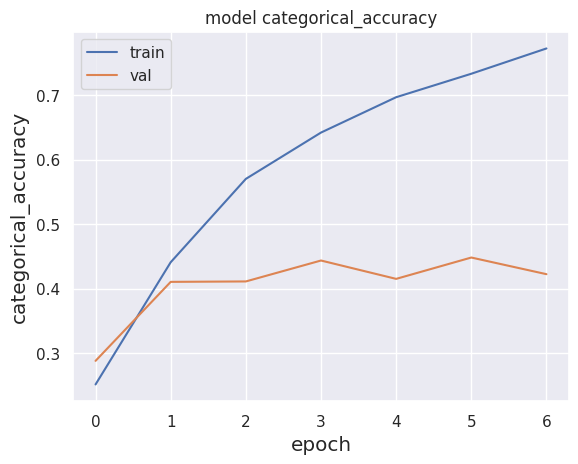

In [27]:
metric = "categorical_accuracy"
if override_model:
    plt.figure()
    plt.plot(history.history[metric])
    plt.plot(history.history["val_" + metric])
    plt.title("model " + metric)
    plt.ylabel(metric, fontsize="large")
    plt.xlabel("epoch", fontsize="large")
    plt.legend(["train", "val"], loc="best")
    with open(os.path.join(models_folder, f'{model_name}_{metric}.pickle'), 'wb') as f:
        fig = plt.gcf()
        pickle.dump(fig, f)
else:
    with open(os.path.join(models_folder, f'{model_name}_{metric}.pickle'), 'rb') as f:
        fig = pickle.load(f)
fig.show()

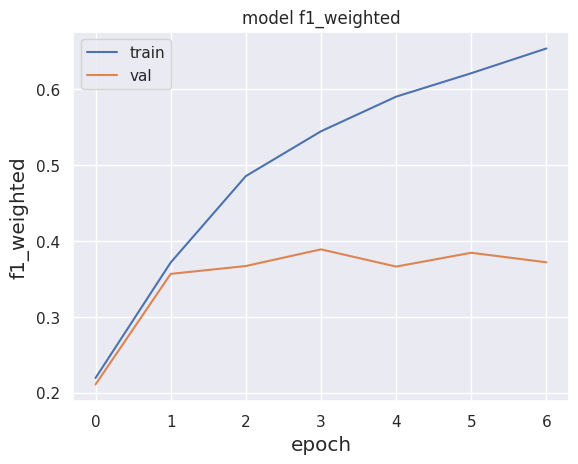

In [28]:
metric = "f1_weighted"
if override_model:
    plt.figure()
    plt.plot(history.history[metric])
    plt.plot(history.history["val_" + metric])
    plt.title("model " + metric)
    plt.ylabel(metric, fontsize="large")
    plt.xlabel("epoch", fontsize="large")
    plt.legend(["train", "val"], loc="best")
    with open(os.path.join(models_folder, f'{model_name}_{metric}.pickle'), 'wb') as f:
        fig = plt.gcf()
        pickle.dump(fig, f)
else:
    with open(os.path.join(models_folder, f'{model_name}_{metric}.pickle'), 'rb') as f:
        fig = pickle.load(f)
fig.show()


## Computing resulting metrics on Validation and Test Sets

In [29]:
# VALIDATION EVALUATION

# F1

f1s_metric = Masked_F1(len(label2id), mode='none', name='f1s', ignore_indexes=[label2id[emo] for emo in ignore_emotions])
f1_macro = Masked_F1(len(label2id), mode='macro', name='f1_macro', ignore_indexes=[label2id[emo] for emo in ignore_emotions])
val_f1_weighted_metric = Masked_F1(len(label2id), mode='weighted', name='val_f1_weighted', ignore_indexes=[label2id[emo] for emo in ignore_emotions], dataset_distribution=list(val_distr.values()))

val_preds = model.predict(val_data, batch_size=batch_size, verbose=0)

f1s_metric.update_state(em_val, val_preds)
f1_macro.update_state(em_val, val_preds)
val_f1_weighted_metric.update_state(em_val, val_preds)

val_f1s = f1s_metric.result()
val_f1_macro = f1_macro.result()
val_f1_weighted = val_f1_weighted_metric.result()

f1s_metric.reset_state()
f1_macro.reset_state()
val_f1_weighted_metric.reset_state()

# Categorical Accuracy

val_accuracy_metric = Masked_Categorical_Accuracy(ignore_indexes=[label2id[emo] for emo in ignore_emotions])

val_accuracy_metric.update_state(em_val, val_preds)

val_accuracy = val_accuracy_metric.result()

val_accuracy_metric.reset_state()

# TEST EVALUATION

# F1

test_f1_weighted_metric = Masked_F1(len(label2id), mode='weighted', name='test_f1_weighted', ignore_indexes=[label2id[emo] for emo in ignore_emotions], dataset_distribution=list(test_distr.values()))

start = time.time()
test_preds = model.predict(test_data, batch_size=batch_size, verbose=0)
end = time.time()

f1s_metric.update_state(em_test, test_preds)
f1_macro.update_state(em_test, test_preds)
test_f1_weighted_metric.update_state(em_test, test_preds)

test_f1s = f1s_metric.result()
test_f1_macro = f1_macro.result()
test_f1_weighted = test_f1_weighted_metric.result()

f1s_metric.reset_state()
f1_macro.reset_state()
test_f1_weighted_metric.reset_state()

# Categorical Accuracy

test_accuracy_metric = Masked_Categorical_Accuracy(ignore_indexes=[label2id[emo] for emo in ignore_emotions])

test_accuracy_metric.update_state(em_test, test_preds)

test_accuracy = test_accuracy_metric.result()

test_accuracy_metric.reset_state()

### Exporting results log

In [30]:
# OUTPUT LOG FILE

log_txt = 'Validation f1s:'
log_txt += '\n'
log_txt += f'{val_f1s.numpy()}'
log_txt += '\n'
log_txt += 'val f1 macro:'
log_txt += '\n'
log_txt += f'{val_f1_macro}'
log_txt += '\n'
log_txt += 'val f1 weighted:'
log_txt += '\n'
log_txt += f'{val_f1_weighted}'
log_txt += '\n'
log_txt += 'Test f1s:'
log_txt += '\n'
log_txt += f'{test_f1s.numpy()}'
log_txt += '\n'
log_txt += 'test f1 macro:'
log_txt += '\n'
log_txt += f'{test_f1_macro}'
log_txt += '\n'
log_txt += 'test f1 weighted:'
log_txt += '\n'
log_txt += f'{test_f1_weighted}'
log_txt += '\n'
log_txt += 'test prediction time:'
log_txt += '\n'
log_txt += f'{end - start}'
log_txt += '\n'
log_txt += 'val categorical accuracy:'
log_txt += '\n'
log_txt += f'{val_accuracy}'
log_txt += '\n'
log_txt += 'test categorical accuracy:'
log_txt += '\n'
log_txt += f'{test_accuracy}'



log_file = open(f"/content/gdrive/MyDrive/NLP_models_ArchAndWeights/log_{model_name}_results.txt", "w")
log_file.write(log_txt)
log_file.close()

print(log_txt)

Validation f1s:
[0.26875    0.43659044 0.51862891 0.3358209  0.21022727 0.32599119 0.         0.         0.         0.         0.        ]
val f1 macro:
0.3493347843300161
val f1 weighted:
0.38902263097235307
Test f1s:
[0.35860409 0.38996579 0.4086444  0.37730496 0.18686869 0.3919598  0.         0.         0.         0.         0.        ]
test f1 macro:
0.35222462246411324
test f1 weighted:
0.3718854320279682
test prediction time:
1.5983688831329346
val categorical accuracy:
0.44378307461738586
test categorical accuracy:
0.407449871301651


----------utterance_1321----------


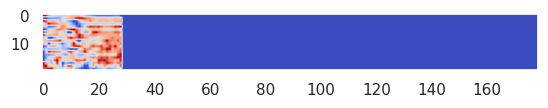

no.
True Label: fru
Predicted Label: sad

----------utterance_836----------


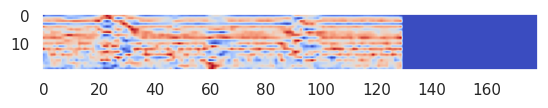

i love you.  okay?
True Label: fru
Predicted Label: hap

----------utterance_413----------


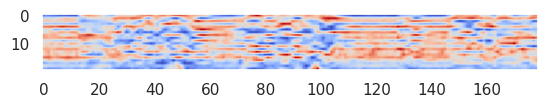

well, congratulations. and to me too, because now i get to-have-
True Label: exc
Predicted Label: sad

----------utterance_522----------


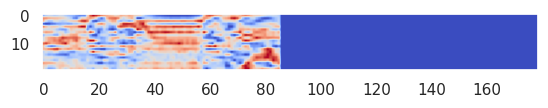

what do you want me to do? what do you want--
True Label: fru
Predicted Label: ang

----------utterance_1035----------


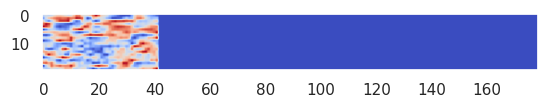

okay.
True Label: exc
Predicted Label: neu



In [31]:
num_samples = 5
true_id = np.argmax(em_test, axis=-1)
pred_id = np.argmax(test_preds, axis=-1)
tp =  true_id == pred_id
ids = np.random.choice(np.sum(~tp), num_samples, replace=False)

id2label = {v:k  for k,v in label2id.items()}
if use_text:
    texts = text_test_ids[~tp,-1,:][ids,:]
if use_audio:
    audios = audio_test[~tp,-1,...][ids,...]
true_em = true_id[~tp][ids]
pred_em = pred_id[~tp][ids]
for i in range(num_samples):
    print('-'*10+f'utterance_{ids[i]}'+'-'*10)
    if use_audio:
        if use_audio_transformers:
            librosa.display.waveplot(audios[i,:], sr=sample_rate)
        else:
            plt.imshow(audios[i,...].T, cmap=cm.coolwarm)
            plt.grid(False)
            plt.show()
    if use_text:
        print(df_test['sentence'].to_numpy()[~tp][ids][i])
    print(f'True Label: {id2label[true_em[i]]}')
    print(f'Predicted Label: {id2label[pred_em[i]]}')
    print()